# Initial Preparation

In [50]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.4 is required in this notebook
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
np.random.seed(42)
tf.random.set_seed(42)

# For changes
USER = "ageent"
REPO = "y-mlOnPhrases"
SKIP_FLAG = "all"    # Maybe "tm1", "tm1_0", "fm1" ... or "all"

X_FILE = "X.npy"
Y1_FILE = "Y1.npy"
Y2_FILE = "Y2.npy"

In [72]:
# to save data or images
if "google.colab" in sys.modules:
    from google.colab import drive
    ROOT_GD = "/content/drive"
    STORAGE_PATH = ROOT_GD + "/My Drive/Colab Notebooks/" + REPO + "/"
    drive.mount(ROOT_GD)
else:   # local host
    STORAGE_PATH = "data/"

def save_data(prefix, file_name, data_frame):
    path = STORAGE_PATH + prefix + file_name
    data_frame.to_csv(path)

def save_pred(file_name, data_frame):
    save_data("predictions/", file_name, data_frame)
def save_trans_data(file_name, data_frame):
    save_data("transformed/", file_name, data_frame)

"""
fig, ax = plt.subplots()
ax.plot(data)
save_fig(fig, "fig_name")
"""
def save_fig(fig_id, fig=plt, tight_layout=True, fig_extension="png", resolution=300):
    path = STORAGE_PATH + "img/" + fig_id + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        fig.tight_layout()
    fig.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# get the data
def get_github_data(path_to_file):
    """TODO: maybe need to use requests."""
    url = "https://raw.githubusercontent.com/{}/{}/{}"\
                            .format(USER, REPO, path_to_file)
    return np.load(url)

def get_localhost_data(file_name):
    path = "data/src/" + file_name
    return np.load(path)

if "google.colab" in sys.modules:
    PATH_TO_SRC = "main/data/src/"
    X_DATA = get_github_data(PATH_TO_SRC + X_FILE)
    Y1_DATA = get_github_data(PATH_TO_SRC + Y1_FILE)
    Y2_DATA = get_github_data(PATH_TO_SRC + Y2_FILE)
else:   # local host
    X_DATA = get_localhost_data(X_FILE)
    Y1_DATA = get_localhost_data(Y1_FILE)
    Y2_DATA = get_localhost_data(Y2_FILE)

In [4]:
print(X_DATA.shape)
print(X_DATA[0])

(800, 128)
[-0.98200285  5.3519163   0.6241017  -3.7863977  -2.0433748  -1.6433135
  5.0111694   0.11501709 -3.3202858   2.2631938   4.487829    3.1017983
  3.4887044  -4.942223    6.474518    0.77631605  5.3201113  -5.003155
 -6.0889516   3.9606059   4.9673815   0.5534823   2.3377123  -3.4211032
  5.278324    1.576092   -5.2838745   0.5925345  -1.2432728   1.5591371
 -1.0380139  -0.1521509   2.4624774   6.4752107  -4.399489   -2.6032155
  3.5712152   0.44489035  1.3303515   0.42398357  2.2737198   7.777598
 -3.3040464  -2.2658207  -7.7937617  -0.6868003   7.5321355   0.5417963
  2.423962    7.1077695  -0.6353128   3.4406264  -2.3372521   0.1237992
  1.9296596   4.452048    2.1478891  -2.770266   -9.235324   10.521325
 -8.574103   -3.127737   -5.1270823   5.001681   -2.710712    0.44150203
 -0.15498942  0.24662127 -0.21252623 -1.7166231  -1.0460446  -5.4344797
  2.56957    10.698443   -3.0771906   1.0651661  -0.32124305  5.725385
  7.167192    5.156452    5.6941953   6.4998055   6.7241

In [5]:
print(Y1_DATA.shape)
print(Y1_DATA[0:10])

(800,)
[1 2 2 0 1 0 2 2 1 0]


In [6]:
print(Y2_DATA.shape)
print(Y2_DATA[0:10])

(800,)
[ 6. 15. 34. 58. 27. 29. 50. 12.  7. 17.]


# Feature engineering
### Transforming

In [7]:
x = X_DATA.copy()
y2 = Y2_DATA.copy()

In [8]:
from sklearn.preprocessing import OneHotEncoder

transformer_y1 = OneHotEncoder()

In [9]:
y1 = transformer_y1.fit_transform(Y1_DATA[:, np.newaxis]).toarray()
y1

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

### Shuffle

In [23]:
t_ = np.hstack([x, y1, y2[:, np.newaxis]])
t_.shape

(800, 132)

In [24]:
np.random.shuffle(t_)
x = t_[:, :128].copy()
y1 = t_[:, 128:131].copy()
y2 = t_[:, 131].copy()
y = tf.concat([y1, y2[:, tf.newaxis]], axis=1)
%reset_selective -f t_

# Model selection
### Model 1
Сoefficient w_cl in loss1 is 1.0.
#### Loss and metrics

In [12]:
def classifier_metric(y_true, y_pred):
    return keras.metrics.categorical_accuracy(y_true[:, :3], y_pred)

def regressor_metric(y_true, y_pred):
    y_true_reg = tf.cast(y_true[:, 3], tf.float32)
    y_pred = tf.cast(y_pred, tf.float64)
    w_reg = 1 / 3
    y_pred_w = tf.cast(y_pred * w_reg, tf.float32)
    y_pred_reg = tf.reduce_sum(y_pred_w, axis=1)
    return tf.metrics.mean_squared_error(y_true_reg, y_pred_reg)

In [13]:
# test for metrics
y_true_ = tf.constant([[1, 0, 0, 60],
                       [0 ,1, 0, 50],
                       [0, 0, 1, 20],
                       [0, 1, 0, 4]])
y_pred_ = tf.constant([[99, 0, 0],
                       [0, 99, 0],
                       [0, 99, 9],
                       [0, 99, 0]])
print(classifier_metric(y_true_, y_pred_))
print(regressor_metric(y_true_, y_pred_))

tf.Tensor([1. 1. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(528.75, shape=(), dtype=float32)


In [37]:
def get_summands(y_true, y_pred, w_cl):
    y_true_cl_ = tf.cast(y_true[:, :3], tf.float32)
    y_true_reg_ = tf.cast(y_true[:, 3], tf.float32)
    y_pred_ = tf.cast(y_pred, tf.float32)

    # classification
    y_pred_max = tf.reduce_max(y_pred_, axis=1)[:, tf.newaxis]
    y_pred_norm = y_pred_ / y_pred_max
    ss_cl = tf.square(y_true_cl_ - y_pred_norm) * w_cl

    # regression
    w_reg = 1 / 3
    y_pred_w = tf.cast(y_pred_ * w_reg, tf.float32)
    y_pred_reg = tf.reduce_sum(y_pred_w, axis=1)
    ss_reg = tf.square(y_true_reg_ - y_pred_reg)

    return tf.concat([ss_cl, ss_reg[:, tf.newaxis]], 1)

def loss1(y_true, y_pred):
    summands = get_summands(y_true, y_pred, 1.)
    return tf.reduce_sum(summands)

In [15]:
# test for loss1
y_true_ = tf.constant([[1, 0, 0, 60],
                       [0 ,1, 0, 50],
                       [2, 0, 1, 20],
                       [0, 1, 0, 4]])
y_pred_ = tf.constant([[99, 0, 0],
                       [0, 99, 0],
                       [1, 0, 99],
                       [0, 99, 0]])
loss1(y_true_, y_pred_)

<tf.Tensor: shape=(), dtype=float32, numpy=2042.3776>

#### Create model

In [41]:
if SKIP_FLAG.find("tm1") != -1 or SKIP_FLAG.find("all") != -1:
    model1 = keras.models.Sequential()
    model1.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    model1.compile(loss=loss1,
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=[classifier_metric, regressor_metric])
    history1 = model1.fit(x, y, epochs=300, validation_split=0.2)

Epoch 1/300
20/20 [==============================] - 5s 33ms/step - loss: 3224.1958 - classifier_metric: 0.3156 - regressor_metric: 99.3955 - val_loss: 477.1639 - val_classifier_metric: 0.3313 - val_regressor_metric: 13.6223
Epoch 2/300
20/20 [==============================] - 0s 7ms/step - loss: 523.1818 - classifier_metric: 0.3156 - regressor_metric: 15.0431 - val_loss: 524.7948 - val_classifier_metric: 0.3313 - val_regressor_metric: 15.1149
Epoch 3/300
20/20 [==============================] - 0s 7ms/step - loss: 377.3031 - classifier_metric: 0.3156 - regressor_metric: 10.4836 - val_loss: 440.5504 - val_classifier_metric: 0.3313 - val_regressor_metric: 12.4814
Epoch 4/300
20/20 [==============================] - 0s 8ms/step - loss: 326.5594 - classifier_metric: 0.3156 - regressor_metric: 8.8988 - val_loss: 390.7339 - val_classifier_metric: 0.3313 - val_regressor_metric: 10.9281
Epoch 5/300
20/20 [==============================] - 0s 13ms/step - loss: 294.3036 - classifier_metric: 0.3

### Model 2

In [17]:
def loss2(y_true, y_pred):
    summands = get_summands(y_true, y_pred)
    cl_mul = tf.reduce_sum(summands[:, :3], axis=1)
    reg_mul = summands[:, 3]
    return tf.reduce_sum(cl_mul * reg_mul)

In [18]:
# test for loss2
y_true_ = tf.constant([[1, 0, 0, 60],
                       [0 ,1, 0, 50],
                       [2, 0, 1, 20],
                       [0, 1, 0, 4]])
y_pred_ = tf.constant([[99, 0, 0],
                       [0, 99, 0],
                       [1, 0, 99],
                       [0, 99, 0]])
loss2(y_true_, y_pred_)

<tf.Tensor: shape=(), dtype=float32, numpy=995.5302>

In [19]:
if SKIP_FLAG.find("tm2") != -1 or SKIP_FLAG.find("all") != -1:
    model2 = keras.models.Sequential()
    model2.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    model2.compile(loss=loss2,
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1),
                   metrics=[classifier_metric, regressor_metric])
    history2 = model2.fit(x, y, epochs=30, validation_split=0.2)

### Model 3

In [20]:
def loss3(y_true, y_pred):
    y_true_cl_ = tf.cast(y_true[:, :3], tf.float32)
    y_true_reg_ = tf.cast(y_true[:, 3], tf.float32)
    y_pred_ = tf.cast(y_pred, tf.float32)

    # classification
    y_pred_max = tf.reduce_max(y_pred_, axis=1)[:, tf.newaxis]
    y_pred_norm = y_pred_ / y_pred_max
    ss_cl = tf.square(y_true_cl_ - y_pred_norm)

    # regression
    w_reg = 1 / 3
    thr = tf.sqrt(2.)
    y_pred_w = tf.cast(y_pred_ * w_reg, tf.float32)
    y_pred_reg = tf.reduce_sum(y_pred_w, axis=1)
    delta_reg = y_true_reg_ - y_pred_reg
    is_more_threshold = delta_reg >= thr
    big_grad = tf.square(2. * delta_reg - thr)
    small_grad = tf.square((1/2) * delta_reg) + 1.5
    ss_reg = tf.where(is_more_threshold, big_grad, small_grad)
    summands = tf.concat([ss_cl, ss_reg[:, tf.newaxis]], 1)

    return tf.reduce_sum(summands)

In [21]:
# test for loss3
y_true_ = tf.constant([[1, 0, 0, 60],
                       [0 ,1, 0, 50],
                       [2, 0, 1, 20],
                       [0, 1, 0, 4]])
y_pred_ = tf.constant([[99, 0, 0],
                       [0, 99, 0],
                       [1, 0, 99],
                       [0, 99, 0]])
loss3(y_true_, y_pred_)

<tf.Tensor: shape=(), dtype=float32, numpy=4088.7522>

In [22]:
if SKIP_FLAG.find("tm3") != -1 or SKIP_FLAG.find("all") != -1:
    model3 = keras.models.Sequential()
    model3.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    model3.compile(loss=loss3,
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                   metrics=[classifier_metric, regressor_metric])
    history3 = model3.fit(x, y, epoch=200, validation_split=0.2)

# Setting up the model
Model 1 selected.

In [48]:
def loss1_w(w_cl=1.):
    def loss1_(y_true, y_pred):
        summands = get_summands(y_true, y_pred, w_cl)
        return tf.reduce_sum(summands)
    return loss1_

### Final model 1.0

In [96]:
if SKIP_FLAG.find("tm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    finmod1_0 = keras.models.Sequential()
    finmod1_0.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    finmod1_0.compile(loss=loss1_w(),
                      optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                      metrics=[classifier_metric, regressor_metric])
    history1_0 = finmod1_0.fit(x, y, epochs=300, validation_split=0.2)

Epoch 1/300
20/20 [==============================] - 5s 65ms/step - loss: 1486.6909 - classifier_metric: 0.3094 - regressor_metric: 45.1602 - val_loss: 554.7834 - val_classifier_metric: 0.3187 - val_regressor_metric: 16.0540
Epoch 2/300
20/20 [==============================] - 0s 10ms/step - loss: 361.2966 - classifier_metric: 0.3109 - regressor_metric: 10.0225 - val_loss: 336.2276 - val_classifier_metric: 0.3187 - val_regressor_metric: 9.2536
Epoch 3/300
20/20 [==============================] - 0s 12ms/step - loss: 154.9730 - classifier_metric: 0.3125 - regressor_metric: 3.5865 - val_loss: 172.3401 - val_classifier_metric: 0.3187 - val_regressor_metric: 4.1334
Epoch 4/300
20/20 [==============================] - 0s 14ms/step - loss: 122.9975 - classifier_metric: 0.3187 - regressor_metric: 2.6038 - val_loss: 151.9980 - val_classifier_metric: 0.3187 - val_regressor_metric: 3.5125
Epoch 5/300
20/20 [==============================] - 0s 15ms/step - loss: 112.4311 - classifier_metric: 0.32

In [97]:
if SKIP_FLAG.find("tm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    finmod1_0.compile(loss=loss1_w(),
                   optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   metrics=[classifier_metric, regressor_metric])
    history1_0a = finmod1_0.fit(x, y, epochs=100, validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 4s 54ms/step - loss: 44.4432 - classifier_metric: 0.9609 - regressor_metric: 1.0573 - val_loss: 78.0552 - val_classifier_metric: 0.9250 - val_regressor_metric: 2.0005
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 37.5272 - classifier_metric: 0.9609 - regressor_metric: 0.8415 - val_loss: 58.6677 - val_classifier_metric: 0.9250 - val_regressor_metric: 1.3911
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 34.2673 - classifier_metric: 0.9609 - regressor_metric: 0.7394 - val_loss: 67.9778 - val_classifier_metric: 0.9250 - val_regressor_metric: 1.6852
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 35.4667 - classifier_metric: 0.9609 - regressor_metric: 0.7771 - val_loss: 56.8021 - val_classifier_metric: 0.9250 - val_regressor_metric: 1.3322
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 34.8606 - classifier_metric: 0.9609 - regressor_me

Saving figure mod1.0_loss1


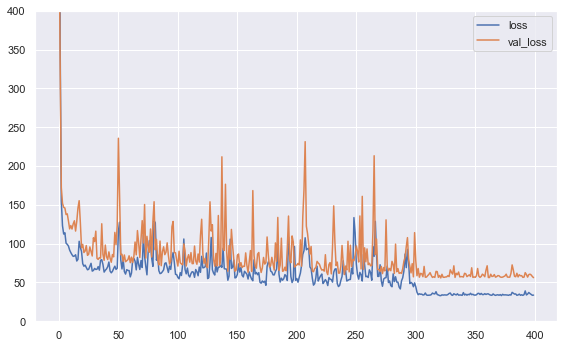

In [98]:
if SKIP_FLAG.find("tm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    df_h1_0 = pd.concat([pd.DataFrame(history1_0.history),
                         pd.DataFrame(history1_0a.history)], ignore_index=True)
    df_h1_0.iloc[:, [0, 3]].plot(figsize=(8, 5))
    plt.gca().set_ylim(0, 400)
    save_fig("mod1.0_loss1")

Saving figure mod1.0_clMetric


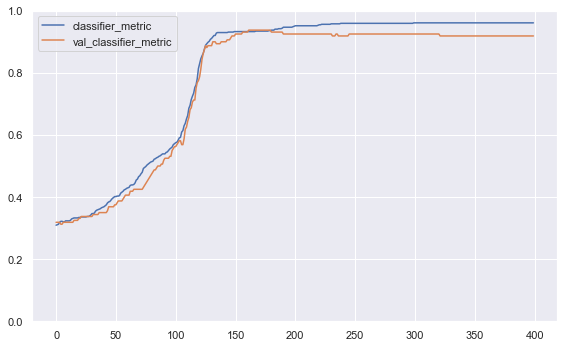

In [99]:
if SKIP_FLAG.find("tm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    df_h1_0.iloc[:, [1, 4]].plot(figsize=(8, 5))
    plt.gca().set_ylim(0, 1)
    save_fig("mod1.0_clMetric")

Saving figure mod1.0_regMetric


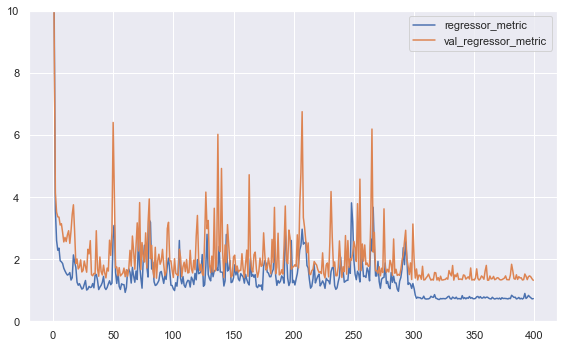

In [100]:
if SKIP_FLAG.find("tm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    df_h1_0.iloc[:, [2, 5]].plot(figsize=(8, 5))
    plt.gca().set_ylim(0, 10)
    save_fig("mod1.0_regMetric")

### Final model 1.1

In [51]:
if SKIP_FLAG.find("fm1_1") != -1 or SKIP_FLAG.find("all") != -1:
    finmod1_1 = keras.models.Sequential()
    finmod1_1.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    finmod1_1.compile(loss=loss1_w(tf.sqrt(2.)),
                   optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   metrics=[classifier_metric, regressor_metric])
    history1_1 = finmod1_1.fit(x, y, epochs=800, validation_split=0.2)

Epoch 1/800
20/20 [==============================] - 6s 46ms/step - loss: 3242.2151 - classifier_metric: 0.3156 - regressor_metric: 99.3951 - val_loss: 494.2296 - val_classifier_metric: 0.3313 - val_regressor_metric: 13.6218
Epoch 2/800
20/20 [==============================] - 0s 8ms/step - loss: 540.5246 - classifier_metric: 0.3156 - regressor_metric: 15.0443 - val_loss: 541.8452 - val_classifier_metric: 0.3313 - val_regressor_metric: 15.1160
Epoch 3/800
20/20 [==============================] - 0s 5ms/step - loss: 394.6108 - classifier_metric: 0.3156 - regressor_metric: 10.4839 - val_loss: 457.4993 - val_classifier_metric: 0.3313 - val_regressor_metric: 12.4796
Epoch 4/800
20/20 [==============================] - 0s 5ms/step - loss: 343.8234 - classifier_metric: 0.3156 - regressor_metric: 8.8987 - val_loss: 407.6267 - val_classifier_metric: 0.3313 - val_regressor_metric: 10.9265
Epoch 5/800
20/20 [==============================] - 0s 5ms/step - loss: 311.5221 - classifier_metric: 0.31

### Final model 1.2

In [39]:
# Take into account the average loss for the classifier outputs
if SKIP_FLAG.find("fm1_2") != -1 or SKIP_FLAG.find("all") != -1:
    finmod1_2 = keras.models.Sequential()
    finmod1_2.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    finmod1_2.compile(loss=loss1_w(tf.sqrt(2.) * (1/3)),
                   optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                   metrics=[classifier_metric, regressor_metric])
    history1_2 = finmod1_2.fit(x, y, epochs=200, validation_split=0.2)

Epoch 1/200
20/20 [==============================] - 5s 66ms/step - loss: 3735.6641 - classifier_metric: 0.3328 - regressor_metric: 116.0538 - val_loss: 946.9343 - val_classifier_metric: 0.3750 - val_regressor_metric: 28.9659
Epoch 2/200
20/20 [==============================] - 0s 7ms/step - loss: 558.4402 - classifier_metric: 0.3359 - regressor_metric: 16.7921 - val_loss: 267.7725 - val_classifier_metric: 0.3750 - val_regressor_metric: 7.7385
Epoch 3/200
20/20 [==============================] - 0s 6ms/step - loss: 222.5142 - classifier_metric: 0.3391 - regressor_metric: 6.2961 - val_loss: 189.8469 - val_classifier_metric: 0.3750 - val_regressor_metric: 5.3045
Epoch 4/200
20/20 [==============================] - 0s 7ms/step - loss: 137.7942 - classifier_metric: 0.3391 - regressor_metric: 3.6544 - val_loss: 143.8435 - val_classifier_metric: 0.3812 - val_regressor_metric: 3.8704
Epoch 5/200
20/20 [==============================] - 0s 6ms/step - loss: 114.9665 - classifier_metric: 0.3391 

# Unloading parameters
Selected model 1.0.

In [110]:
weights = finmod1_0.layers[0].get_weights()[0]
weights.shape

(128, 3)

In [113]:
w_reg = 1 / 3
coefficients = np.array([w_reg for x in range(3)])
coefficients.shape

(3,)

In [116]:
result = {
    'matrix': weights.tolist(),
    'coefficients': coefficients.tolist()
}

In [117]:
import json
with open("result.json", "w") as f:
    json.dump(result, f)